# Import

In [64]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from matplotlib import ticker
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.utils import resample
import seaborn

# PCA analysis 


In [65]:
"""
This script includes:
    -PCA analysis across sessions (airpuff & non-airpuff)
    -First principal component boxplot with sessions & trials as datapoints across sessions (airpuff & non-airpuff)
    -Average of explained variance boxplot with sessions & trials as datapoints across sessions 
    (airpuff & non-airpuff)
    -Plotting explained variance change across all sessions
    -Difference between explained variance & straight line across sessions (airpuff & non-airpuff)
    -Activity in each time window for each session & across sessions (mean & variance)

---------
Python 3.8.5

Dependencies:
    -numpy 1.19.2
    -pandas 1.1.3
    -scipy 1.6.3
    -matplotlib 3.3.2
    -seaborn 0.11.0
    -sklearn 0.0
    -csv, os, pickle
"""

'\nThis script includes:\n    -PCA analysis across sessions (airpuff & non-airpuff)\n    -First principal component boxplot with sessions & trials as datapoints across sessions (airpuff & non-airpuff)\n    -Average of explained variance boxplot with sessions & trials as datapoints across sessions \n    (airpuff & non-airpuff)\n    -Plotting explained variance change across all sessions\n    -Difference between explained variance & straight line across sessions (airpuff & non-airpuff)\n    -Activity in each time window for each session & across sessions (mean & variance)\n\n---------\nPython 3.8.5\n\nDependencies:\n    -numpy 1.19.2\n    -pandas 1.1.3\n    -scipy 1.6.3\n    -matplotlib 3.3.2\n    -seaborn 0.11.0\n    -sklearn 0.0\n    -csv, os, pickle\n'

In [118]:
#### change chosen animal!!
chosen_animal = 233

if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','11','12','13'] # animal 233
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')



# PCA and first principal component - sessions as datapoints

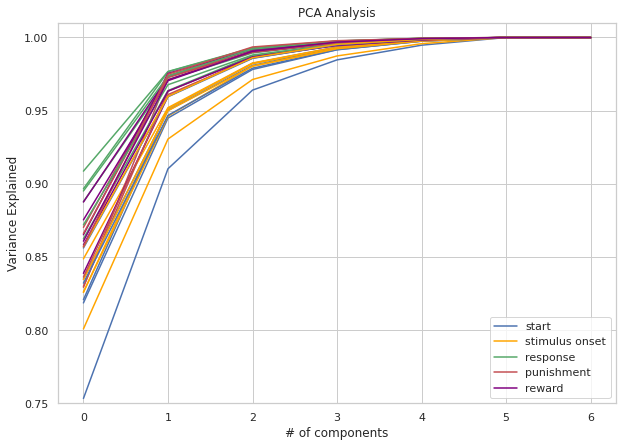

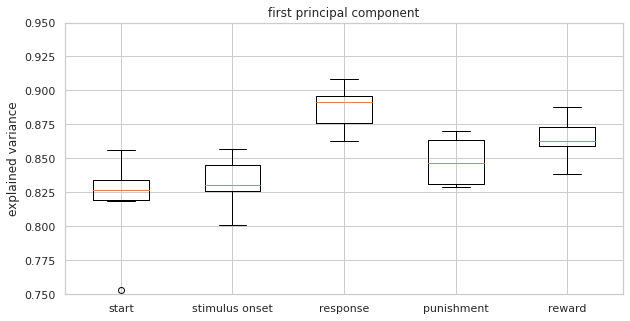

In [123]:
# labels for plotting
label1 = 'start'
label2 = 'stimulus onset'
label3 = 'response'
label4 = 'punishment'
label5 = 'reward'

# initiate empty lists
first_var_start = []
first_var_stim_onset = []
first_var_resp = []
first_var_punish = []
first_var_reward = []

# create figure
fig = plt.subplots(figsize =(10, 7))

# for each airpuff session:
for session in airpuff_sessions:

    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    variances_start = []
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>5: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_start.append(var_trial)
    var_start = np.mean(variances_start, axis=0)

    # stimulus onset
    variances_stim_onset = []
    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>5: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_stim_onset.append(var_trial)
    var_stim_onset = np.mean(variances_stim_onset, axis=0)

    # response
    variances_resp = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>5: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_resp.append(var_trial)
    var_resp = np.mean(variances_resp, axis=0)

    # punishment
    variances_punish = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            if len(x)>5: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_punish.append(var_trial)
    var_punish = np.mean(variances_punish, axis=0)
    
    # reward
    variances_reward = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            if len(x)>5: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_reward.append(var_trial)
    var_reward = np.mean(variances_reward, axis=0)
    
    first_var_start.append(var_start[0])
    first_var_stim_onset.append(var_stim_onset[0])
    first_var_resp.append(var_resp[0])
    first_var_punish.append(var_punish[0])
    first_var_reward.append(var_reward[0])
    
    # plotting
    plt.plot(var_start, label=label1, color='b')
    plt.plot(var_stim_onset, label=label2, color='orange')
    plt.plot(var_resp, label=label3, color='g')
    plt.plot(var_punish, label=label4, color='r')
    plt.plot(var_reward, label=label5, color='purple')
    
    label1='_nolegend_'
    label2='_nolegend_'
    label3='_nolegend_'
    label4='_nolegend_'
    label5='_nolegend_'
    
plt.ylabel('Variance Explained')
plt.xlabel('# of components')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.ylim(0.75,1.01)
#plt.xlim(0,10)
#plt.yscale('log')
plt.legend()
plt.show()

    
# plotting    
data = [first_var_start, first_var_stim_onset, first_var_resp, first_var_punish, first_var_reward]
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('first principal component')
ax.boxplot(data)
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
ax.set_ylim(0.75, 0.95)
ax.set_ylabel('explained variance')
plt.show()
    
    

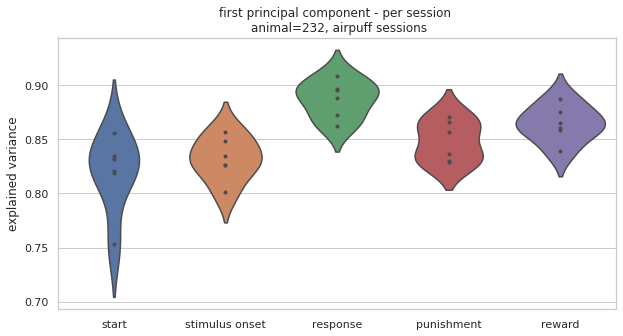

In [124]:
# violin plot of first PC
    

fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('first principal component - per session \n animal=232, airpuff sessions')
# use to set style of background of plot
seaborn.set(style = 'whitegrid') 
  

pddata = [pd.DataFrame(np.array(first_var_start)), pd.DataFrame(np.array(first_var_stim_onset)), pd.DataFrame(np.array(first_var_resp)), pd.DataFrame(np.array(first_var_punish)), pd.DataFrame(np.array(first_var_reward))]
seaborn.violinplot(data = pddata, inner="points")
#seaborn.swarmplot(data = pddata,color= "white")

#ax.boxplot(data)
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
#ax.set_ylim(0.75, 0.95)
ax.set_ylabel('explained variance')
plt.show()
    


In [125]:
import copy
import random


# set this in recurrent loop to test all significances

#############################################################################################
variables = [first_var_start, first_var_stim_onset, first_var_resp, first_var_punish, first_var_reward]
pval_matrix = np.ones(shape=(len(variables),len(variables))) 
parametric_test_matrix =np.ones(shape=(len(variables), len(variables))) 

for j in range(len(variables)):
    for i in range(len(variables)):
        
        # change variable1 and variable2 to compute permutation and t-tests between them:
        # first_var_start  first_var_stim_onset  first_var_resp  first_var_punish  first_var_reward
        variable1 = variables[j]
        variable2 = variables[i]


        # Compute the ground truth absolute difference Δτ between τ₁ and τ₂ from your two variables:
        gT = np.abs(np.mean(variable1) - np.mean(variable2))

        # Pool your variables into one single distribution:
        pV = list(variable1) + list(variable2)

        # Randomly sample (also called bootstrapping) without replacement two distributions 
        # with the size equal to the original distributions from this pooled distribution 
        # to compute the absolute difference RΔτ of your metric between your two permuted samples:
        # and repeat this p times:

        # Copy pooled distribution:
        pS = copy.copy(pV)
        # Initialize permutation:
        pD = []
        # Define p (number of permutations):
        p=10000
        # Permutation loop:
        for k in range(0,p):
          # Shuffle the data:
            random.shuffle(pS)
            surrogate_var1 = pS[0:int(len(pS)/2)]
            surrogate_var2 = pS[int(len(pS)/2):]

            # Compute permuted absolute difference of your two sampled distributions and store it in pD:
            pD.append(np.abs(np.mean(surrogate_var1) - np.mean(surrogate_var2)))

        # Finally, the proportion of permuted differences higher than your ground truth difference 
        # is your significance value:
        # is there any permutation where the difference between the surrogate distributions is hi
        
        pval_matrix[j,i] = np.sum(np.array(pD)>=np.array(gT))/p
        parametric_test_matrix[j,i] = scipy.stats.stats.ttest_ind(variable1, variable2)[1]
        


<ipython-input-125-fac88687f512>:53: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  parametric_test_matrix[j,i] = scipy.stats.stats.ttest_ind(variable1, variable2)[1]


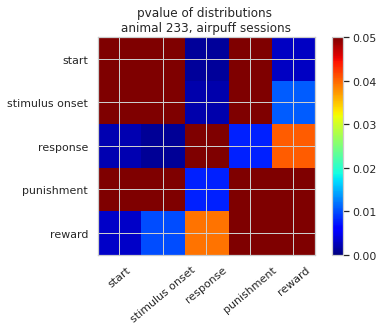

In [126]:
plt.imshow(pval_matrix, cmap='jet', vmin=0.0, vmax=0.05)
plt.title('pvalue of distributions \n animal 233, airpuff sessions ')
plt.xticks([0,1,2,3,4],['start', 'stimulus onset', 'response', 'punishment', 'reward'], rotation=40)

plt.yticks([0,1,2,3,4],['start', 'stimulus onset', 'response', 'punishment', 'reward'])
plt.colorbar()
plt.show()

In [76]:
a = scipy.stats.stats.ttest_ind(variable1, variable2)

<ipython-input-76-3b69979554bd>:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  a = scipy.stats.stats.ttest_ind(variable1, variable2)


In [79]:
a[0]

-3.7919612656438537

# PCA and first principal component - trials as datapoints

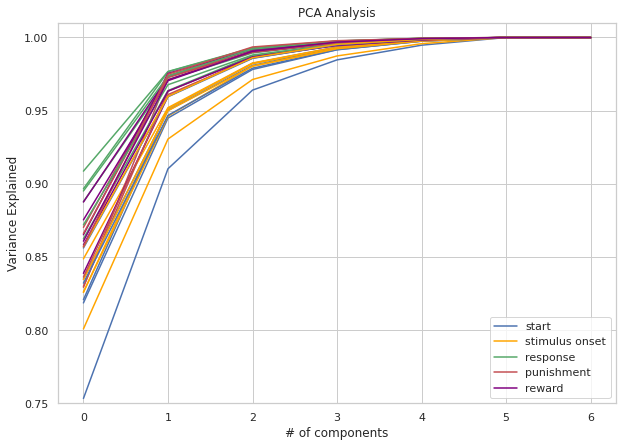

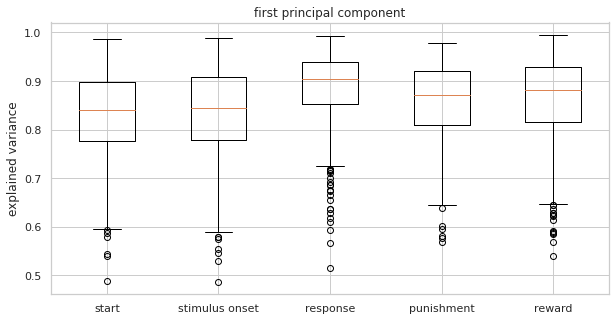

In [62]:
# labels for plotting
label1 = 'start'
label2 = 'stimulus onset'
label3 = 'response'
label4 = 'punishment'
label5 = 'reward'

# initiate empty lists
first_var_start = []
first_var_stim_onset = []
first_var_resp = []
first_var_punish = []
first_var_reward = []

# create figure
fig = plt.subplots(figsize =(10, 7))

# for each airpuff session:
for session in airpuff_sessions:

    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.5
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    variances_start = []
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>5: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
            first_var_start.append(var_trial[0])
        variances_start.append(var_trial)
    var_start = np.mean(variances_start, axis=0)

    # stimulus onset
    variances_stim_onset = []
    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>5: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
            first_var_stim_onset.append(var_trial[0])
        variances_stim_onset.append(var_trial)
    var_stim_onset = np.mean(variances_stim_onset, axis=0)

    # response
    variances_resp = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>5: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
            first_var_resp.append(var_trial[0])
        variances_resp.append(var_trial)
    var_resp = np.mean(variances_resp, axis=0)

    # punishment
    variances_punish = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            if len(x)>5: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
                first_var_punish.append(var_trial[0])
        variances_punish.append(var_trial)
    var_punish = np.mean(variances_punish, axis=0)
    
    # reward
    variances_reward = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            if len(x)>5: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
                first_var_reward.append(var_trial[0])
        variances_reward.append(var_trial)
    var_reward = np.mean(variances_reward, axis=0)
    
        
    # plotting
    plt.plot(var_start, label=label1, color='b')
    plt.plot(var_stim_onset, label=label2, color='orange')
    plt.plot(var_resp, label=label3, color='g')
    plt.plot(var_punish, label=label4, color='r')
    plt.plot(var_reward, label=label5, color='purple')
    
    label1='_nolegend_'
    label2='_nolegend_'
    label3='_nolegend_'
    label4='_nolegend_'
    label5='_nolegend_'
    
plt.ylabel('Variance Explained')
plt.xlabel('# of components')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.ylim(0.75,1.01)
#plt.xlim(0,10)
#plt.yscale('log')
plt.legend()
plt.show()

    
# plotting    
data = [first_var_start, first_var_stim_onset, first_var_resp, first_var_punish, first_var_reward]
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('first principal component')
ax.boxplot(data)
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
#ax.set_ylim(0.75, 0.95)
ax.set_ylabel('explained variance')
plt.show()
    
    

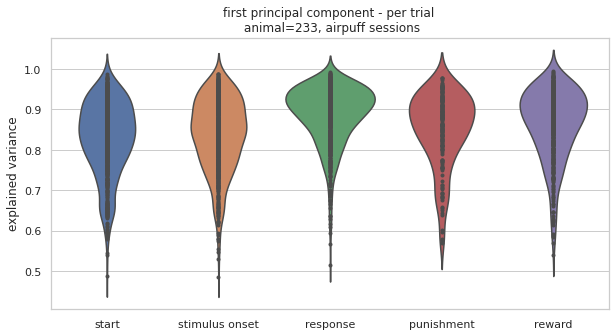

In [63]:
# Violin plot

fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('first principal component - per trial \n animal=233, airpuff sessions')
# use to set style of background of plot
seaborn.set(style = 'whitegrid') 
  

pddata = [pd.DataFrame(np.array(first_var_start)), pd.DataFrame(np.array(first_var_stim_onset)), pd.DataFrame(np.array(first_var_resp)), pd.DataFrame(np.array(first_var_punish)), pd.DataFrame(np.array(first_var_reward))]
seaborn.violinplot(data = pddata, inner="points")
#seaborn.swarmplot(data = pddata,color= "white")

#ax.boxplot(data)
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
#ax.set_ylim(0.75, 0.95)
ax.set_ylabel('explained variance')
plt.show()


In [ ]:
# TODO statistical testing

In [ ]:
# change variable1 and variable2 to compute permutation and t-tests between them:
# first_var_start  first_var_stim_onset  first_var_resp  first_var_punish  first_var_reward
variable1 = first_var_punish
variable2 = first_var_reward

# Compute the ground truth absolute difference Δτ between τ₁ and τ₂ from your two variables:
gT = np.abs(np.average(variable1) - np.average(variable2))

# Pool your variables into one single distribution:
pV = list(variable1) + list(variable2)

# Randomly sample (also called bootstrapping) without replacement two distributions 
# with the size equal to the original distributions from this pooled distribution 
# to compute the absolute difference RΔτ of your metric between your two permuted samples:
# and repeat this p times:

# Copy pooled distribution:
pS = copy.copy(pV)
# Initialize permutation:
pD = []
# Define p (number of permutations):
p=1000
# Permutation loop:
for i in range(0,p):
  # Shuffle the data:
    random.shuffle(pS)
    # Compute permuted absolute difference of your two sampled distributions and store it in pD:
    pD.append(np.abs(np.average(pS[0:int(len(pS)/2)]) - np.average(pS[int(len(pS)/2):])))
    
# Finally, the proportion of permuted differences higher than your ground truth difference 
# is your significance value:
p_val = len(np.where(pD>=gT)[0])/p
print("permutation test: pvalue =", p_val)
# Compare with parametric t-test:
print("parametric t-test:", scipy.stats.stats.ttest_ind(variable1, variable2))

# average of explained variance curve boxplot (airpuff) - sessions as datapoints

In [ ]:
# initiate empty lists
mean_var_start = []
mean_var_stim_onset = []
mean_var_resp = []
mean_var_punish = []
mean_var_reward = []

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time)
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    variances_start = []
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_start.append(var_trial)
    var_start = np.mean(variances_start, axis=0)

    # stimulus onset
    variances_stim_onset = []
    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_stim_onset.append(var_trial)
    var_stim_onset = np.mean(variances_stim_onset, axis=0)

    # response
    variances_resp = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_resp.append(var_trial)
    var_resp = np.mean(variances_resp, axis=0)

    # punishment
    variances_punish = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_punish.append(var_trial)
    var_punish = np.mean(variances_punish, axis=0)
    
    # reward
    variances_reward = []
    for idx in X:
        # only reward trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_end_time[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_reward.append(var_trial)
    var_reward = np.mean(variances_reward, axis=0)

    mean_var_start.append(np.mean(var_start))
    mean_var_stim_onset.append(np.mean(var_stim_onset))
    mean_var_resp.append(np.mean(var_resp))
    mean_var_punish.append(np.mean(var_punish))
    mean_var_reward.append(np.mean(var_reward))
    
    
# plotting    
data = [mean_var_start, mean_var_stim_onset, mean_var_resp, mean_var_punish, mean_var_reward]
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('average of explained variance')
ax.boxplot(data)
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
ax.set_ylim(0.95, 0.99)
ax.set_ylabel('explained variance')
plt.show()

# average principal components (airpuff) - trials as datapoints

In [ ]:
# initiate empty lists
variances_start = []
variances_stim_onset = []
variances_resp = []
variances_punish = []
variances_reward = []
tot_trials = 0

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    #tot_trials = tot_trials + n_trials # total number of trials across sessions
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)
    tot_trials = tot_trials + n_trials # total number of trials across sessions

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_start.append(np.mean(var_trial))

    # stimulus onset
    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_stim_onset.append(np.mean(var_trial))

    # response
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_resp.append(np.mean(var_trial))

    # punishment
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_punish.append(np.mean(var_trial))
    
    # reward
    for idx in X:
        # only reward trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_end_time[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_reward.append(np.mean(var_trial))
    
# plotting    
data = [variances_start, variances_stim_onset, variances_resp, variances_punish, variances_reward]
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('average of explained variance')
ax.boxplot(data)
ax.set_xticklabels(['start', 'stimulus onset', 'response', 'punishment', 'reward'])
ax.set_ylabel('explained variance')
ax.set_ylim(0.86, 1.01)
plt.show()

In [ ]:
# total number of trials across airpuff sessions
tot_trials

# Y-axis explained variance, X-axis session number, one colour per condition (reward, punishment, etc)

In [ ]:
# initiate empty lists
first_var_start = []
first_var_stim_onset = []
first_var_resp = []
first_var_punish = []
first_var_reward = []

# for each airpuff session: 
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time)
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    variances_start = []
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_start.append(var_trial)
    var_start = np.mean(variances_start, axis=0)

    # stimulus onset
    variances_stim_onset = []
    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_stim_onset.append(var_trial)
    var_stim_onset = np.mean(variances_stim_onset, axis=0)

    # response
    variances_resp = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_resp.append(var_trial)
    var_resp = np.mean(variances_resp, axis=0)

    # punishment
    variances_punish = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_punish.append(var_trial)
    var_punish = np.mean(variances_punish, axis=0)
    
    # reward
    variances_reward = []
    for idx in X:
        # only reward trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_end_time[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_reward.append(var_trial)
    var_reward = np.mean(variances_reward, axis=0)

    first_var_start.append(var_start[0])
    first_var_stim_onset.append(var_stim_onset[0])
    first_var_resp.append(var_resp[0])
    first_var_punish.append(var_punish[0])
    first_var_reward.append(var_reward[0])
    

# plotting    
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('first principal component')
ax.plot(range(14,20), first_var_start, 'b', label='start')
ax.plot(range(14,20), first_var_stim_onset, 'orange', label='stimulus onset')
ax.plot(range(14,20), first_var_resp, 'g', label='response')
ax.plot(range(14,20), first_var_punish, 'r', label='punishment')
ax.plot(range(14,20), first_var_reward, 'purple', label='reward')
ax.set_ylabel('explained variance')
ax.set_xlabel('session')
ax.set_ylim(0.75, 0.95)
ax.legend()
plt.show()

PCA plot: Y-axis explained variance, X-axis session number, one colour per condition (reward, punishment, etc). You can make two versions of it, one with the explained variance of the first PC; the second with the difference between the explained variance of the model across PC component and a straight line: 

sum( ExpVar - linspace(0,1,num_PC))

# new plot version 2: difference between the explained variance of the model across PC component and a straight line

In [ ]:
# set labels and title for plot
label1 = 'start'
label2 = 'stimulus onset'
label3 = 'response'
label4 = 'punishment'
label5 = 'reward'
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('first principal component')

# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time)
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    variances_start = []
    for idx in X:
        x = X[idx][start_timepoint:n_after_start]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_start.append(var_trial)
    var_start = np.mean(variances_start, axis=0)

    # stimulus onset
    variances_stim_onset = []
    for idx in X:
        stim_timepoint = int((trials_stimulus_on[idx] - new_start[idx]) /sampling_rate)
        x = X[idx][stim_timepoint-n_before_stim:stim_timepoint + n_after_stim]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_stim_onset.append(var_trial)
    var_stim_onset = np.mean(variances_stim_onset, axis=0)

    # response
    variances_resp = []
    for idx in X:
        resp_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate)
        x = X[idx][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
        if len(x)>6: # make sure that time window is not too small
            covar_matrix = PCA(n_components=n_components)
            covar_matrix.fit(x)
            variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
            var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_resp.append(var_trial)
    var_resp = np.mean(variances_resp, axis=0)

    # punishment
    variances_punish = []
    for idx in X:
        # only punishment trials
        if trials_is_reward[idx]==0:
            # timepoint for response
            resp_airpuff_timepoint = int((trials_response[idx] - new_start[idx]) / sampling_rate) + airpuff
            x = X[idx][resp_airpuff_timepoint-n_before_pun:resp_airpuff_timepoint+n_after_pun]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_punish.append(var_trial)
    var_punish = np.mean(variances_punish, axis=0)
    
    # reward
    variances_reward = []
    for idx in X:
        # only reward trials
        if trials_is_reward[idx]==1:
            # timepoint for response
            resp_timepoint = int((trials_end_time[idx] - new_start[idx]) / sampling_rate)
            x = X[idx][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            if len(x)>6: # make sure that time window is not too small
                covar_matrix = PCA(n_components=n_components)
                covar_matrix.fit(x)
                variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
                var_trial = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3))
        variances_reward.append(var_trial)
    var_reward = np.mean(variances_reward, axis=0)

    # plotting each condition for each session
    ax.plot(var_start - np.linspace(0,1,n_components), 'b', label=label1)
    ax.plot(var_stim_onset - np.linspace(0,1,n_components), 'orange', label=label2)
    ax.plot(var_resp - np.linspace(0,1,n_components), 'g', label=label3)
    ax.plot(var_punish - np.linspace(0,1,n_components), 'r', label=label4)
    ax.plot(var_reward - np.linspace(0,1,n_components), 'purple', label=label5)
    
    label1='_nolegend_'
    label2='_nolegend_'
    label3='_nolegend_'
    label4='_nolegend_'
    label5='_nolegend_'
    
    
# plotting    
ax.set_ylabel('explained variance')
ax.set_xlabel('number of principal components')
#ax.set_ylim(0.6, 0.95)
#ax.set_xlim(0,2)
ax.legend()
plt.show()

# activity in each time window across sessions

In [ ]:
# initiate empty lists
mean_start = []
mean_stim = []
mean_resp = []
mean_pun = []
mean_rew = []
var_start = []
var_stim = []
var_resp = []
var_pun = []
var_rew = []

# for each non-airpuff session:
for session in list_session:

    # load csv calcium traces
    folder_name = "Calcium_Traces/"    
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))
    for i in range(1,len(time_array)):
        time_sampling[i-1] = time_array[i]-time_array[i-1]

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # load the behavioral data
    #folder_name = "trial_info" #/no_airpuff"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #trials_finish_reward = trial_info['trial_info'][0,0][6].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim

    # start of trial
    start_window = {}
    selected_trials = ((trials_response - new_start)/sampling_rate > n_after_start)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        if selected_trials[i]==1:
            start_window[i] = X[i][start_timepoint:n_after_start]   
    mean_activity = np.array([start_window[i] for i in start_window]).mean(axis=0) # mean of trials
    mean_activity = np.mean(mean_activity, axis=0) # mean of timepoints
    mean_activity_start = np.mean(mean_activity)
    var_activity = np.array([start_window[i] for i in start_window]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_start = np.var(var_activity)

    # stimulus onset
    stim_onset_window = {}
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # timepoints for stimulus onset and end of trial
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
        stim_onset_window[i] = X[i][stim_timepoint-n_before_stim:stim_timepoint+n_after_stim]
    # only trials with time window of 7
    stim_onset_window_corr = {}
    for i in range(n_trials_):
        if len(stim_onset_window[i])>6:
            stim_onset_window_corr[i] = stim_onset_window[i]
    mean_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_stim = np.mean(mean_activity)
    var_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_stim = np.var(var_activity)

    # response
    resp_window = {}
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # timepoints for response and end of trial
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        resp_window[i] = X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
    # only trials with time window of 7
    resp_window_corr = {}
    for i in range(n_trials_):
        if len(resp_window[i])>6:
            resp_window_corr[i] = resp_window[i]
    mean_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_resp = np.mean(mean_activity)
    var_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_resp = np.var(var_activity)

    # punishment
    punish_window = {}
    j=0
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoints for response and end of trial
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            punish_window[j] = X[i][resp_timepoint-n_before_pun:resp_timepoint+n_after_pun]
            j+=1
    # only trials with time window of 7
    punish_window_corr = {}
    for i in range(len(punish_window)):
        if len(punish_window[i])>6:
            punish_window_corr[i] = punish_window[i]
    mean_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_pun = np.mean(mean_activity)
    var_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_pun = np.var(var_activity)
    
    # reward
    rew_window = {}
    j=0
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoints for response and end of trial
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            rew_window[j] = X[i][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            j+=1
    # only trials with time window of 7
    rew_window_corr = {}
    for i in range(len(rew_window)):
        if len(rew_window[i])>6:
            rew_window_corr[i] = rew_window[i]
    mean_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_rew = np.mean(mean_activity)
    var_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_rew = np.var(var_activity)

    mean_start.append(mean_activity_start)
    mean_stim.append(mean_activity_stim)
    mean_resp.append(mean_activity_resp)
    mean_pun.append(mean_activity_pun)
    mean_rew.append(mean_activity_rew)
    var_start.append(var_activity_start)
    var_stim.append(var_activity_stim)
    var_resp.append(var_activity_resp)
    var_pun.append(var_activity_pun)
    var_rew.append(var_activity_rew)
    



# for each airpuff session:
for session in range(14,20):

    # LOAD CSV CALCIUM TRACES
    folder_name = "Calcium_Traces/"
    filename = "2021-05-{0}.csv".format(session)
    df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    # check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
    time_sampling = np.zeros(shape=(len(time_array)-1,))

    #12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
    sampling_rate = 0.1
    tot_secs = int(tot_timepoints * sampling_rate)

    # create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    #folder_name = "trial_info"
    #bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    #trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    #trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    #trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    #trials_response = trial_info['trial_info'][0,0][2].ravel()
    #trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    #trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    #trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    #n_trials = len(trials_end_time) # number of trials
    
    # load behavioural data (.pkl file)
    input_filename = "trial_info/trial_info_2021-05-{0}.pkl".format(session)
    with open(os.path.join(animal_folder_name,input_filename), 'rb') as fp:
         trial_info = pickle.load(fp)

    # extract information for trial_info: in PYTHON
    trials_start_time = np.array(trial_info['start_time'])
    trials_stimulus_on = np.array(trial_info['stimulus_on'])
    trials_response = np.array(trial_info['response'])
    trials_is_right_lick = np.array(trial_info['is_right_lick'])
    trials_is_reward = np.array(trial_info['is_reward'])
    trials_end_time = np.array(trial_info['end_trial'])
    n_trials = len(trials_end_time)

    # 500msec between start and stimulus onset
    new_start = [] # initiate empty list
    new_end = [] # initiate empty list
    new_start.append(trials_stimulus_on[0]-0.5) # append first start
    new_end.append(trials_stimulus_on[1]-0.5) # append first end
    for i in range(1,n_trials-1): # append start & end times for each trial (except last)
        new_start.append(trials_stimulus_on[i]-0.5)
        new_end.append(trials_stimulus_on[i+1]-0.5)
    new_start.append(trials_stimulus_on[n_trials-1]-0.5) # append last start
    new_end.append(trials_end_time[n_trials-1]) # append last end
    new_start = np.array(new_start) # turn list to array
    new_end = np.array(new_end)
    n_trials = len(new_end)
    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]
        
        
    ###### across all trials for this session
    n_components = 7
    start_timepoint = 0
    n_after_start = 7
    n_before_stim = 2
    n_after_stim = 5
    n_before_resp = 5
    n_after_resp = 2
    n_before_pun = 2
    n_after_pun = 5
    n_before_rew = 2
    n_after_rew = 5
    time_window = n_before_stim+n_after_stim
    airpuff = 2

    # start of trial
    start_window = {}
    selected_trials = ((trials_response - new_start)/sampling_rate > n_after_start)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        if selected_trials[i]==1:
            start_window[i] = X[i][start_timepoint:n_after_start]   
    mean_activity = np.array([start_window[i] for i in start_window]).mean(axis=0) # mean of trials
    mean_activity = np.mean(mean_activity, axis=0) # mean of timepoints
    mean_activity_start = np.mean(mean_activity)
    var_activity = np.array([start_window[i] for i in start_window]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_start = np.var(var_activity)

    # stimulus onset
    stim_onset_window = {}
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # timepoints for stimulus onset and end of trial
        stim_timepoint = int((trials_stimulus_on[i] - new_start[i]) /sampling_rate)
        stim_onset_window[i] = X[i][stim_timepoint-n_before_stim:stim_timepoint+n_after_stim]
    # only trials with time window of 7
    stim_onset_window_corr = {}
    for i in range(n_trials_):
        if len(stim_onset_window[i])>6:
            stim_onset_window_corr[i] = stim_onset_window[i]
    mean_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_stim = np.mean(mean_activity)
    var_activity = np.array([stim_onset_window_corr[i] for i in stim_onset_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_stim = np.var(var_activity)

    # response
    resp_window = {}
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # timepoints for response and end of trial
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)    
        resp_window[i] = X[i][resp_timepoint - n_before_resp:resp_timepoint+n_after_resp]
    # only trials with time window of 7
    resp_window_corr = {}
    for i in range(n_trials_):
        if len(resp_window[i])>6:
            resp_window_corr[i] = resp_window[i]
    mean_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_resp = np.mean(mean_activity)
    var_activity = np.array([resp_window_corr[i] for i in resp_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_resp = np.var(var_activity)

    # punishment
    punish_window = {}
    j=0
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # only punishment trials
        if trials_is_reward[i]==0:
            # timepoints for response and end of trial
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)+airpuff
            punish_window[j] = X[i][resp_timepoint-n_before_pun:resp_timepoint+n_after_pun]
            j+=1
    # only trials with time window of 7
    punish_window_corr = {}
    for i in range(len(punish_window)):
        if len(punish_window[i])>6:
            punish_window_corr[i] = punish_window[i]
    mean_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_pun = np.mean(mean_activity)
    var_activity = np.array([punish_window_corr[i] for i in punish_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_pun = np.var(var_activity)
    
    # reward
    rew_window = {}
    j=0
    selected_trials = ((trials_response - new_start)/sampling_rate > time_window)
    n_trials_ = np.sum(selected_trials)
    for i in range(n_trials_):
        # only reward trials
        if trials_is_reward[i]==1:
            # timepoints for response and end of trial
            resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
            rew_window[j] = X[i][resp_timepoint-n_before_rew:resp_timepoint+n_after_rew]
            j+=1
    # only trials with time window of 7
    rew_window_corr = {}
    for i in range(len(rew_window)):
        if len(rew_window[i])>6:
            rew_window_corr[i] = rew_window[i]
    mean_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).mean(axis=0)
    mean_activity = np.mean(mean_activity, axis=0)
    mean_activity_rew = np.mean(mean_activity)
    var_activity = np.array([rew_window_corr[i] for i in rew_window_corr]).var(axis=0)
    var_activity = np.var(var_activity, axis=0)
    var_activity_rew = np.var(var_activity)

    mean_start.append(mean_activity_start)
    mean_stim.append(mean_activity_stim)
    mean_resp.append(mean_activity_resp)
    mean_pun.append(mean_activity_pun)
    mean_rew.append(mean_activity_rew)
    var_start.append(var_activity_start)
    var_stim.append(var_activity_stim)
    var_resp.append(var_activity_resp)
    var_pun.append(var_activity_pun)
    var_rew.append(var_activity_rew)
    
# plotting mean
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('mean neuron activity')
x = np.arange(len(mean_start))
ax.bar(x-0.3,mean_start, color='b', width=0.15, label='start')
ax.bar(x-0.15,mean_stim, color='orange', width=0.15, label='stimulus onset')
ax.bar(x,mean_resp, color='g', width=0.15, label='response')
ax.bar(x+0.15,mean_pun, color='r', width=0.15, label='punishment')
ax.bar(x+0.3,mean_rew, color='purple', width=0.15, label='reward')
ax.axvline(7.5, c='k', label='airpuff sessions')
# x-tick labels
positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(all_sessions))
ax.set_ylabel('mean neuron activity')
ax.set_xlabel('session')
#ax.set_ylim(0.65, 0.9)
ax.legend()
plt.show()

# plotting variance
fig, ax = plt.subplots(figsize =(10, 5))
ax.set_title('variance neuron activity')
x = np.arange(len(var_start))
ax.bar(x-0.3,var_start, color='b', width=0.15, label='start')
ax.bar(x-0.15,var_stim, color='orange', width=0.15, label='stimulus onset')
ax.bar(x,var_resp, color='g', width=0.15, label='response')
ax.bar(x+0.15,var_pun, color='r', width=0.15, label='punishment')
ax.bar(x+0.3,var_rew, color='purple', width=0.15, label='reward')
ax.axvline(7.5, c='k', label='airpuff sessions')
# x-tick labels
positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(all_sessions))
ax.set_ylabel('variance neuron activity')
ax.set_xlabel('session')
#ax.set_ylim(0.65, 0.9)
ax.legend()
plt.show()

In [ ]:
# plotting mean neuron activity for each time window across sessions - same animal as before
means = []
means.append(mean_start[0:8])
means.append(mean_stim[0:8])
means.append(mean_resp[0:8])
means.append(mean_pun[0:8])
means.append(mean_rew[0:8])
means_ap = []
means_ap.append(mean_start[8:14])
means_ap.append(mean_stim[8:14])
means_ap.append(mean_resp[8:14])
means_ap.append(mean_pun[8:14])
means_ap.append(mean_rew[8:14])

fig, axs = plt.subplots(1,2,figsize =(15, 5))
x = np.arange(len(np.mean(means, axis=1)))
axs[0].bar(x,np.mean(means, axis=1), color='b', width=0.5)
axs[1].bar(x,np.mean(means_ap,axis=1),color='b',width=0.5)

# x-tick labels
positions = [0,1,2,3,4]
labels = ['start','stimulus','response','punishment','reward']
for ax in axs.flat:
    ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax.set(xlabel='time window', ylabel='mean neuron activity')
    ax.set_ylim(4,7)
axs[0].set_title('no airpuff')
axs[1].set_title('airpuff')
plt.show()


# plotting variance neuron activity for each time window across sessions
variances = []
variances.append(var_start[0:8])
variances.append(var_stim[0:8])
variances.append(var_resp[0:8])
variances.append(var_pun[0:8])
variances.append(var_rew[0:8])
variances_ap = []
variances_ap.append(var_start[8:14])
variances_ap.append(var_stim[8:14])
variances_ap.append(var_resp[8:14])
variances_ap.append(var_pun[8:14])
variances_ap.append(var_rew[8:14])

fig, axs = plt.subplots(1,2,figsize =(15, 5))
x = np.arange(len(np.var(variances, axis=1)))
axs[0].bar(x,np.var(variances, axis=1), color='b', width=0.5)
axs[1].bar(x,np.var(variances_ap,axis=1),color='b',width=0.5)

# x-tick labels
positions = [0,1,2,3,4]
labels = ['start','stimulus','response','punishment','reward']

for ax in axs.flat:
    ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax.set(xlabel='time window', ylabel='mean neuron activity')
    ax.set_ylim(0,np.max(np.var(variances_ap, axis=1))+15570581352.894043)
axs[0].set_title('no airpuff')
axs[1].set_title('airpuff')
plt.show()